# Facial Expression Classification and Feature Extraction

#### By Maria Gil Rodriguez

## 1. Introduction

It is a well-known fact that human beings are responsible for the depiction of six basic emotions: **happiness, anger, surprise, sadness, fear**, and **disgust**. Creating a model that can accurately classify these emotions can be extremely useful in a variety of areas such as image processing, cybersecurity, robotics, psychological studies, virtual reality applications, etc. 

The **main objective** of this capstone is to categorize faces based on the emotion shown in the expression into one of seven categories (the six basic emotions plus one category for neutral).

We will:
* Explore the creation of features with supervised techniques: PCA and LBP
* Use those features to run supervised learning classification models: Random forest and ?
* Use pretrained CNN for the classification
* Create our own CNN and compare the results
* Explore the feature extraction from these CNN
* Put the model in production

## 2. The Dataset

The data I will be using is part of a Kaggle competition. It consists of **48x48 pixel grayscale images** of faces and can be found in:
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data. 

As we will see later, it consists on a .csv file with the class, the usage (training, validation or test set), and an array with the values of the pixels.

However, for ease to use, when working with the fast.ai library, we are going to use this other version of the exact same dataset, were the images are .jpg files in folders:
https://www.kaggle.com/aspiring1/fer2013-images

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *
current_palette = sns.color_palette('GnBu_d',7)
sns.set_palette(current_palette)

Using TensorFlow backend.


In [2]:
# Indicate the paths for the two datasets (.csv and images)
path = '../input/fer2013-images/images/images_fer2013/Training'
path2 = '../input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013/fer2013/fer2013.csv'
wd = '/kaggle/working' # Create a working directory to save files created

# Create ImageDataBunch (from fastai library)
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), bs=128)

print(f'Number of images:\nTraining: {len(data.train_ds)}, Validation: {len(data.valid_ds)}')

Number of images:
Training: 22968, Validation: 5741


And, for each set, we have the following classes.

In [3]:
classes = data.classes
print(classes)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


Let's see some examples of images:

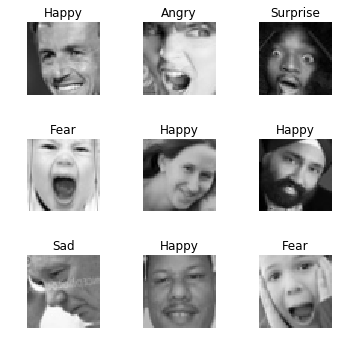

In [4]:
data.show_batch(rows=3, figsize=(5,5))

### *Analysis of the data*

In [5]:
# Load .csv file and remove duplicates
df_raw = pd.read_csv(path2)
df_raw.drop_duplicates(subset='pixels', keep = False, inplace = True) 
from sklearn.utils import shuffle
df_raw = shuffle(df_raw, random_state=42)
df_raw.head()

,emotion,pixels,Usage
17554,3,110 113 124 137 163 176 181 181 178 176 174 17...,Training
924,2,132 110 103 148 141 122 116 93 81 92 82 69 72 ...,Training
4502,0,33 33 32 52 65 70 70 67 63 55 52 52 54 57 63 6...,Training
27640,3,21 17 19 65 100 64 60 48 144 132 43 22 37 91 4...,Training
18498,3,93 56 73 73 62 15 8 62 78 93 132 137 141 166 1...,Training


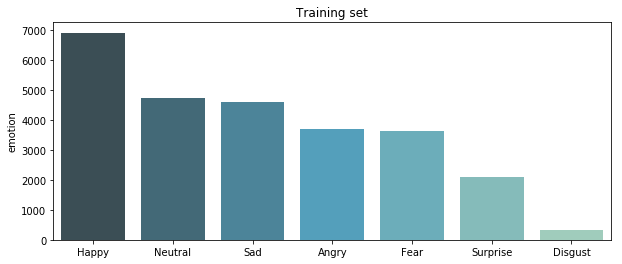

In [6]:
plt.figure(figsize=(10,4))
labels = ['Happy', 'Neutral', 'Sad', 'Angry', 'Fear','Surprise', 'Disgust']
plt.title('Training set')
sns.barplot(labels, df_raw[df_raw['Usage'] == 'Training'].emotion.value_counts())
plt.show()

## 3. Pre-processing

In [7]:
# Pixels in array 
df_raw['pixels'] = df_raw['pixels'].apply(lambda im: np.fromstring(im, sep=' '))

# Separate train and validation set
df = df_raw[['emotion', 'pixels']][df_raw['Usage'] == 'Training']
df.head()

,emotion,pixels
17554,3,"[110.0, 113.0, 124.0, 137.0, 163.0, 176.0, 181..."
924,2,"[132.0, 110.0, 103.0, 148.0, 141.0, 122.0, 116..."
4502,0,"[33.0, 33.0, 32.0, 52.0, 65.0, 70.0, 70.0, 67...."
27640,3,"[21.0, 17.0, 19.0, 65.0, 100.0, 64.0, 60.0, 48..."
18498,3,"[93.0, 56.0, 73.0, 73.0, 62.0, 15.0, 8.0, 62.0..."


In [8]:
df_train = pd.DataFrame()
df_valid = pd.DataFrame()

for i in range(7):
    df_train = df_train.append(df[df.emotion == i][0:100])
    df_valid = df_valid.append(df[df.emotion == i][100:120])

In [9]:
# Scale and define train and valid X and y
X_train = np.vstack(df_train['pixels'].values)/255 # Is this correct?
y_train = np.array(df_train['emotion'])

X_valid = np.vstack(df_valid['pixels'].values)/255 
y_valid = np.array(df_valid['emotion'])

Let's take a look on the number of elements of each class in both the training and validation set.

In [10]:
print('Train: ', X_train.shape)
print('Valid: ', X_valid.shape)

Train:  (700, 2304)
Valid:  (140, 2304)


We clearly have class imbalance, which is especially pronounce in the category 'Disgust'.

## 4. Classic Supervised Learning Models and Feature Extraction



### * Models*

To run these models, we will create a pipeline.

We will tune our hyperparamenters with grid search and in order to perform cross-validating with oversampling, we will do the following: Inside the cross-validation loop, we will get a sample out and do not use it for anything related oversampling or model building. We will then oversample our minority class, without the excluded sample. Finally, we will use the excluded sample for validation, and the oversampled minority class + the majority class, to create the model.

If we would not do this and oversample before creating the folds, the cross-validation values will be overestimated because the validation set would be oversampled, too, filtering some information.

In [11]:
# Define a function to print the models' results
def print_results(model, X_train, X_valid, y_pred):
    print('Train set score:\t\t', round(model.score(X_train, y_train),2))
    print('Best cross validation score:\t', round(model.best_score_,2))
    print('Validation set score:\t\t', round(model.score(X_valid, y_valid),2))
    print(classification_report(y_valid, y_pred))
    conf_mat = confusion_matrix(y_valid, y_pred)
    sns.heatmap(conf_mat,annot=True, cbar=True, fmt='d',cmap='mako_r')
    plt.show()

#### Random forest

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 1.0
Best cross validation score:	 0.24
Validation set score:		 0.27
              precision    recall  f1-score   support

           0       0.30      0.30      0.30        20
           1       0.08      0.05      0.06        20
           2       0.40      0.40      0.40        20
           3       0.12      0.10      0.11        20
           4       0.19      0.15      0.17        20
           5       0.35      0.70      0.47        20
           6       0.27      0.20      0.23        20

   micro avg       0.27      0.27      0.27       140
   macro avg       0.24      0.27      0.25       140
weighted avg       0.24      0.27      0.25       140



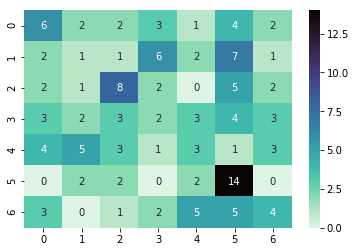

In [12]:
params = {'n_estimators': 50,
          'max_depth': 10}

param_grid = {'n_estimators': [50, 100],
             'max_depth': [10, 20]}

# Initialize and fit the model
rfc = RandomForestClassifier(random_state=42)
grid_rfc = GridSearchCV(rfc, param_grid, return_train_score=False, n_jobs=-1, cv=3)
grid_rfc.fit(X_train, y_train)

# Print results
y_pred = grid_rfc.predict(X_valid)
print_results(grid_rfc, X_train, X_valid, y_pred)

#### Gradient Boosting

Train set score:		 1.0
Best cross validation score:	 0.2
Validation set score:		 0.16
              precision    recall  f1-score   support

           0       0.28      0.25      0.26        20
           1       0.12      0.10      0.11        20
           2       0.00      0.00      0.00        20
           3       0.08      0.10      0.09        20
           4       0.24      0.25      0.24        20
           5       0.21      0.25      0.23        20
           6       0.24      0.20      0.22        20

   micro avg       0.16      0.16      0.16       140
   macro avg       0.17      0.16      0.16       140
weighted avg       0.17      0.16      0.16       140



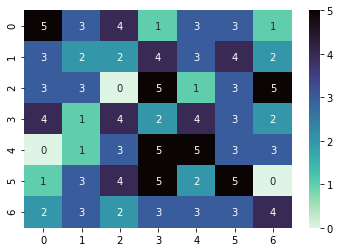

In [13]:
params = {'n_estimators': 100,
          'max_depth': 9,
          'learning_rate': 0.1,
          'loss': 'exponential'}

param_grid = {'n_estimators': [100],
             'max_depth': [9]}

# Initialize and fit the model
gbc = GradientBoostingClassifier(random_state=42)
grid_gbc = GridSearchCV(gbc, param_grid, return_train_score=False, n_jobs=-1, cv=3)
grid_gbc.fit(X_train, y_train)

# Print results 
y_pred = grid_gbc.predict(X_valid)
print_results(grid_gbc, X_train, X_valid, y_pred)

#### SVC

Train set score:		 1.0
Best cross validation score:	 0.21
Validation set score:		 0.23
              precision    recall  f1-score   support

           0       0.14      0.15      0.15        20
           1       0.19      0.25      0.21        20
           2       0.27      0.20      0.23        20
           3       0.21      0.25      0.23        20
           4       0.14      0.10      0.12        20
           5       0.45      0.50      0.48        20
           6       0.18      0.15      0.16        20

   micro avg       0.23      0.23      0.23       140
   macro avg       0.23      0.23      0.22       140
weighted avg       0.23      0.23      0.22       140



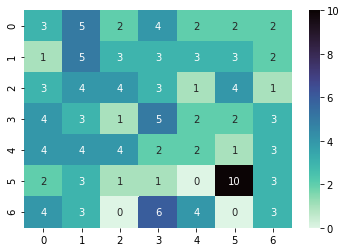

In [14]:
params = {'gamma': ['auto'],
          'kernel': ['linear'],
           'C': [100]}

param_grid = {'gamma': ['auto'],
          'kernel': ['linear'],
           'C': [100]}

# Initialize and fit the model
svc = SVC(**params, random_state=42)
grid_svc = GridSearchCV(svc, param_grid, return_train_score=False, n_jobs=-1, cv=3)
grid_svc.fit(X_train, y_train)

# Print Results
y_pred = grid_svc.predict(X_valid)
print_results(grid_svc, X_train, X_valid, y_pred)

### *PCA*

A way of creating features from our images is to generate Eigen Faces. It simply consist on applyimg Principal Component Analysis (PCA) to our pictures.

Let's perform PCA for 300 components.

If we represent the mean of all the components, we get a sort of mean face (extrictely speakingmean face would be the mean of all the images in the dataset).

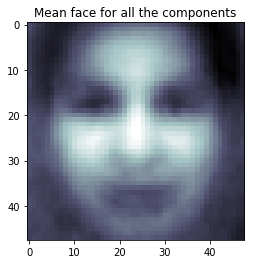

In [15]:
pca = decomposition.PCA(n_components=300)
pca.fit(X_train)
plt.imshow(pca.mean_.reshape(48,48),cmap=plt.cm.bone)
plt.title('Mean face for all the components')
plt.show()

This is pretty cool. It definetely reminds us of a face. 

The fact that it is smiling makes sense, since 'Happy' is the majority class.

Let's take a look of some of the Eigen Faces

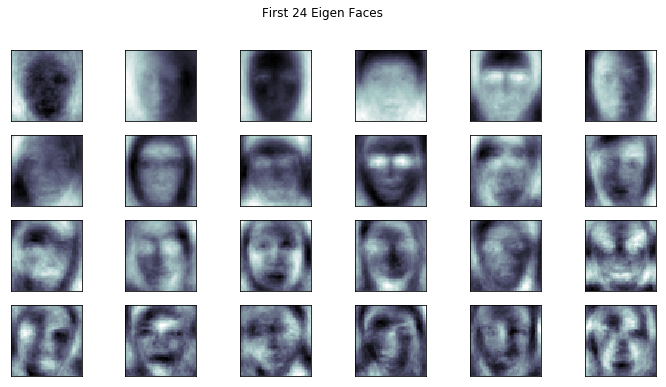

In [16]:
Eigenfaces = pca.components_[0:24]
fig = plt.figure(figsize=(12, 6))

for i in range(24):
    plt.subplot(4, 6, i + 1, xticks=[], yticks=[])
    plt.imshow(Eigenfaces[i].reshape(48,48), cmap=plt.cm.bone)

fig.suptitle('First 24 Eigen Faces')
plt.show()

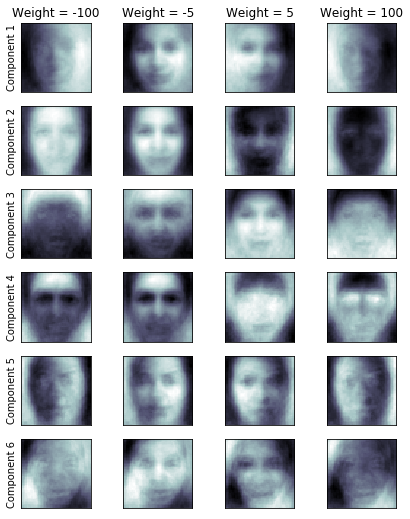

In [17]:
fig = plt.figure(figsize=(7, 12))
weights = [-100, -5, 5, 100]
n = 1
for j in range(1, 7):
    for i in range(len(weights)):
        ax = plt.subplot(8,4,n, xticks=[], yticks=[])
        if n in range(1,5):
            ax.title.set_text('Weight = '+ str(weights[i]))
        if n in range(1,36,4):
            ax.set_ylabel('Component '+ str(j))
        plt.imshow(np.add(pca.mean_.reshape(48,48), (Eigenfaces[j].reshape(48,48)) * weights[i]) 
                   ,cmap=plt.cm.bone)

        n += 1

The first components detect the skin tone and the next in ligh effects: top, bottom, sides, corner...

The following components start focusing on features: eyes, smiles, frowns...

In the following chart, we can see the amount of variance explained by the corresponding number of components.

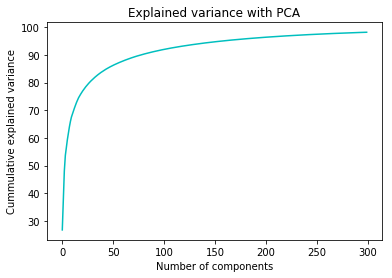

In [18]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100., color='c')
plt.xlabel('Number of components')
plt.ylabel('Cummulative explained variance')
plt.title('Explained variance with PCA')
plt.show()

If we keep 150 components, we get over 90% of the variance. 

Let's now transform X_train and X_valid.

In [19]:
X_train_pca = pca.transform(X_train)[:,:150]
X_valid_pca = pca.transform(X_valid)[:,:150]

#### PCA and Random Forest

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 1.0
Best cross validation score:	 0.19
Validation set score:		 0.14
              precision    recall  f1-score   support

           0       0.08      0.10      0.09        20
           1       0.10      0.15      0.12        20
           2       0.19      0.15      0.17        20
           3       0.05      0.05      0.05        20
           4       0.10      0.05      0.07        20
           5       0.28      0.35      0.31        20
           6       0.12      0.10      0.11        20

   micro avg       0.14      0.14      0.14       140
   macro avg       0.13      0.14      0.13       140
weighted avg       0.13      0.14      0.13       140



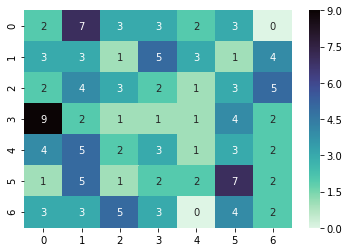

In [20]:
grid_rfc.fit(X_train_pca, y_train)
y_pred = grid_rfc.predict(X_valid_pca)
print_results(grid_rfc, X_train_pca, X_valid_pca, y_pred)

#### PCA and Gradient Boosting

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 1.0
Best cross validation score:	 0.16
Validation set score:		 0.19
              precision    recall  f1-score   support

           0       0.20      0.20      0.20        20
           1       0.17      0.15      0.16        20
           2       0.16      0.15      0.15        20
           3       0.32      0.30      0.31        20
           4       0.20      0.15      0.17        20
           5       0.24      0.20      0.22        20
           6       0.09      0.15      0.12        20

   micro avg       0.19      0.19      0.19       140
   macro avg       0.20      0.19      0.19       140
weighted avg       0.20      0.19      0.19       140



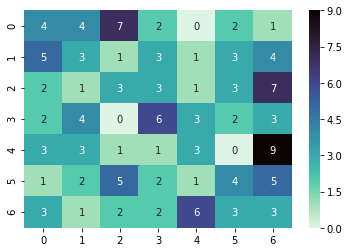

In [21]:
grid_gbc.fit(X_train_pca, y_train)
y_pred = grid_gbc.predict(X_valid_pca)
print_results(grid_gbc, X_train_pca, X_valid_pca, y_pred)

#### PCA and SVC

Train set score:		 1.0
Best cross validation score:	 0.2
Validation set score:		 0.21
              precision    recall  f1-score   support

           0       0.10      0.15      0.12        20
           1       0.24      0.30      0.27        20
           2       0.25      0.25      0.25        20
           3       0.17      0.15      0.16        20
           4       0.20      0.10      0.13        20
           5       0.32      0.35      0.33        20
           6       0.25      0.20      0.22        20

   micro avg       0.21      0.21      0.21       140
   macro avg       0.22      0.21      0.21       140
weighted avg       0.22      0.21      0.21       140



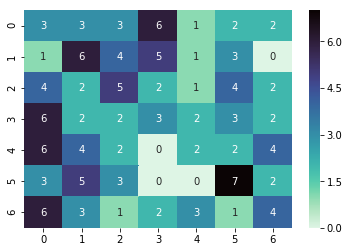

In [22]:
grid_svc.fit(X_train_pca, y_train)
y_pred = grid_svc.predict(X_valid_pca)
print_results(grid_svc, X_train_pca, X_valid_pca, y_pred)

### *Local Binary Patterns*

Another technique to extract features is Local binary patterns (LBP). In this capstone, we will use LBP to filter the features of facial textures.

LBP transforms image blocks into an array of labels. Such labels (or their statistics, for example histograms) are used as features.

In the basic version of the LBP (the one we will be using), we consider the values of a 3x3 pixel neighborhood. For each pixel in a cell, compare the pixel to each of its 8 neighbors (on its left-top, left-middle, left-bottom, right-top, etc.). Follow the pixels along a circle, i.e. clockwise or counter-clockwise. Where the center pixel's value is greater than the neighbor's value, write "0". Otherwise, write "1". This gives an 8-digit binary number (which is usually converted to decimal for convenience).

In [23]:
def lbp(img):
    patterns = []
    pixels = img
    width = 48
    height = 48
    pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]

    # Calculate LBP for each non-edge pixel
    for i in range(1, height - 1):
        # Cache only the rows we need (within the neighborhood)
        previous_row = pixels[i - 1]
        current_row = pixels[i]
        next_row = pixels[i + 1]

        for j in range(1, width - 1):
            # Compare this pixel to its neighbors, starting at the top-left pixel and moving
            # clockwise, and use bit operations to efficiently update the feature vector
            pixel = current_row[j]
            pattern = 0
            pattern = pattern | (1 << 0) if pixel < previous_row[j-1] else pattern
            pattern = pattern | (1 << 1) if pixel < previous_row[j] else pattern
            pattern = pattern | (1 << 2) if pixel < previous_row[j+1] else pattern
            pattern = pattern | (1 << 3) if pixel < current_row[j+1] else pattern
            pattern = pattern | (1 << 4) if pixel < next_row[j+1] else pattern
            pattern = pattern | (1 << 5) if pixel < next_row[j] else pattern
            pattern = pattern | (1 << 6) if pixel < next_row[j-1] else pattern
            pattern = pattern | (1 << 7) if pixel < current_row[j-1] else pattern

            patterns.append(pattern)

    return patterns

We can see now the some examples of the images transformed by LBP.

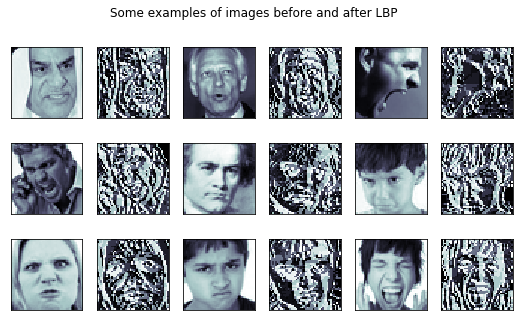

In [24]:
# Transform X_train 
X_train_lbp = pd.DataFrame()
for i in range(len(X_train)):
    X_train_lbp[i] = np.array(lbp(X_train[i]))

# Plot examples
plt.figure(figsize=(9,5))
plt.suptitle('Some examples of images before and after LBP')
for i in range(1,18,2):
    plt.subplot(3,6,i, xticks=[], yticks=[])
    plt.imshow(X_train[i].reshape(48,48), cmap=plt.cm.bone)
    plt.subplot(3,6,i+1, xticks=[], yticks=[])
    plt.imshow(np.array(X_train_lbp[i]).reshape(46,46), cmap=plt.cm.bone)


We can now transform X_valid to run our models.

In [25]:
# Transform X_valid
X_valid_lbp = pd.DataFrame()
for i in range(len(X_valid)):
    X_valid_lbp[i] = np.array(lbp(X_valid[i]))

#### LBP and Random Forest

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 1.0
Best cross validation score:	 0.19
Validation set score:		 0.23
              precision    recall  f1-score   support

           0       0.29      0.45      0.35        20
           1       0.11      0.10      0.11        20
           2       0.24      0.20      0.22        20
           3       0.25      0.25      0.25        20
           4       0.12      0.10      0.11        20
           5       0.21      0.20      0.21        20
           6       0.33      0.30      0.32        20

   micro avg       0.23      0.23      0.23       140
   macro avg       0.22      0.23      0.22       140
weighted avg       0.22      0.23      0.22       140



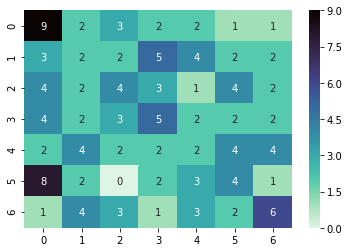

In [26]:
grid_rfc.fit(X_train_lbp.T, y_train)
y_pred = grid_rfc.predict(X_valid_lbp.T)
print_results(grid_rfc, X_train_lbp.T, X_valid_lbp.T, y_pred)

#### LBP and Gradient Boosting

Train set score:		 1.0
Best cross validation score:	 0.16
Validation set score:		 0.15
              precision    recall  f1-score   support

           0       0.19      0.15      0.17        20
           1       0.28      0.40      0.33        20
           2       0.11      0.10      0.11        20
           3       0.06      0.05      0.05        20
           4       0.06      0.05      0.05        20
           5       0.12      0.15      0.13        20
           6       0.17      0.15      0.16        20

   micro avg       0.15      0.15      0.15       140
   macro avg       0.14      0.15      0.14       140
weighted avg       0.14      0.15      0.14       140



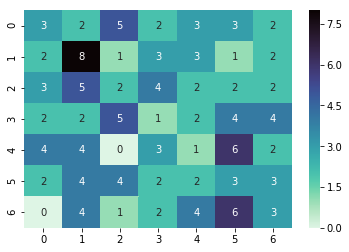

In [27]:
grid_gbc.fit(X_train_lbp.T, y_train)
y_pred = grid_gbc.predict(X_valid_lbp.T)
print_results(grid_gbc, X_train_lbp.T, X_valid_lbp.T, y_pred)

#### LBP and SVC

Train set score:		 1.0
Best cross validation score:	 0.21
Validation set score:		 0.24
              precision    recall  f1-score   support

           0       0.29      0.35      0.32        20
           1       0.16      0.15      0.15        20
           2       0.11      0.10      0.10        20
           3       0.23      0.30      0.26        20
           4       0.25      0.20      0.22        20
           5       0.33      0.35      0.34        20
           6       0.27      0.20      0.23        20

   micro avg       0.24      0.24      0.24       140
   macro avg       0.23      0.24      0.23       140
weighted avg       0.23      0.24      0.23       140



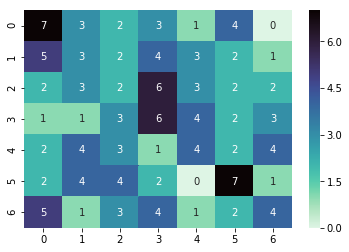

In [28]:
grid_svc.fit(X_train_lbp.T, y_train)
y_pred = grid_svc.predict(X_valid_lbp.T)
print_results(grid_svc, X_train_lbp.T, X_valid_lbp.T, y_pred)

## 5. Convolutional Neural Networks

### *Data Augmentation*

Data augmentation is a technique used to virtually create more instances of the pictures. Every time the CNN grabs an images, it will be slightly different. For humans, they will look the same pictures, but for the computer it is like a brand new one. This helps fighting class imbalance.

The transformations will slightly change:
* Rotation
* Zoom
* Lighting
* Warp
* Padding

The pictures may also be flipped horizontaly.

In [29]:
tfms = get_transforms(max_rotate=20, max_zoom=1.1, max_lighting=0.4, max_warp=0.2, p_affine=1., p_lighting=1.1) #no transforms in valid set                      

These are some examples of the same picture after the transformations are applied:

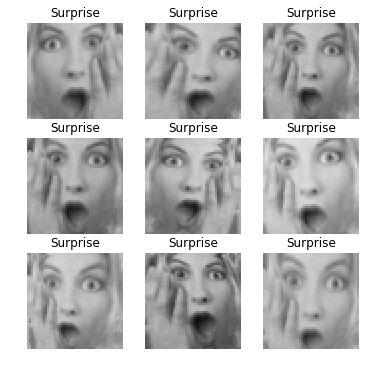

In [30]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(6,6))

### *Pretrained models*

Transfer learning is a popular method in computer vision because it allows us to build accurate models in a timesaving way. Instead of starting the learning process from scratch, we can start from patterns that have been learned when solving a different problem. 

In computer vision, transfer learning is usually expressed through the use of pre-trained models. A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve. 



#### VGG_19:

In [ ]:
#URL = ('http://www.robots.ox.ac.uk/~vgg/software/vgg_face/')
#!pip install URL

In [31]:
np.random.seed(42)
learn = cnn_learner(data, models.vgg19_bn, metrics=accuracy, model_dir='/tmp/model/', pretrained=True) 
#learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir='/tmp/model/')

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /tmp/.torch/models/vgg19_bn-c79401a0.pth
574769405it [00:31, 18489728.15it/s]


In [32]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.780731,1.642293,0.349242,01:13


Wow, that is pretty bad. We are going to adjust the learning rate and run again for more epochs.

In [ ]:
learn.save(wd+'/stage-1')

In [ ]:
#learn.load(wd+'/stage-1')

In [33]:
learn.unfreeze()
learn.lr_find(end_lr=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


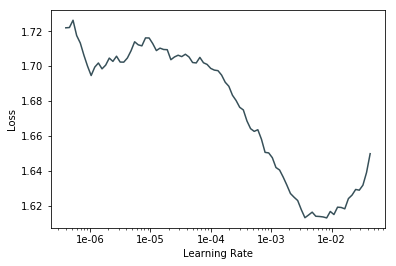

In [34]:
learn.recorder.plot()

In [35]:
learn.unfreeze()
np.random.seed(42)
learn.fit_one_cycle(24, max_lr=slice(2e-3))  #24

epoch,train_loss,valid_loss,accuracy,time
0,1.603578,1.478619,0.420658,00:47
1,1.395575,1.283894,0.507403,00:45
2,1.200281,1.140236,0.566278,00:46
3,1.096498,1.077440,0.595367,00:48
4,1.039555,1.040281,0.620101,00:48
5,0.984754,1.101362,0.605992,00:43
6,0.955774,1.008420,0.624281,00:47
7,0.891745,0.995376,0.635604,00:43
8,0.847837,0.983492,0.638739,00:46
9,0.787121,0.991311,0.645532,00:47


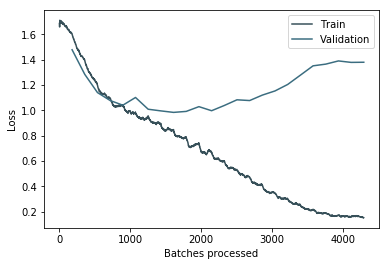

In [36]:
learn.recorder.plot_losses()

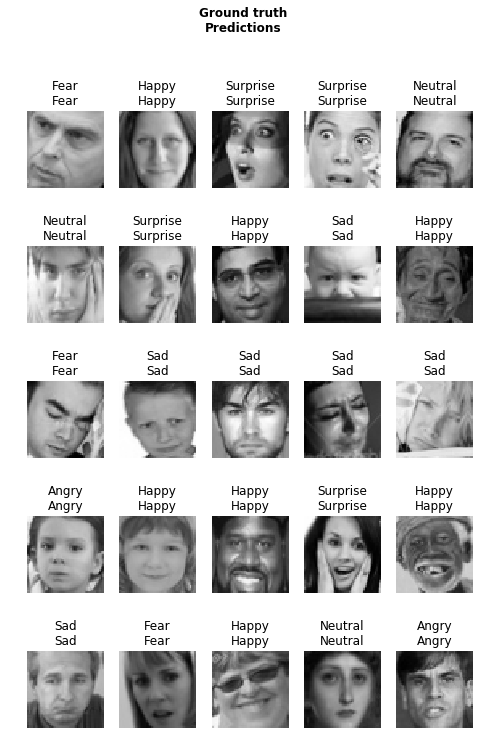

In [42]:
learn.show_results(ds_type=DatasetType.Train, figsize=(8,12))

That is better, but we are clearly overfitting.

Let's take a look on the results in the confusion matrix.

In [ ]:
learn.save(wd+'/stage-2')

In [40]:
#learn.load(wd+'/stage-2')

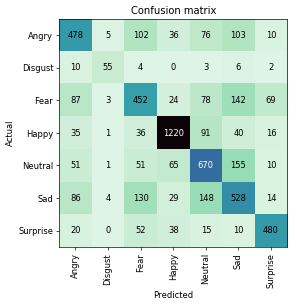

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60, cmap='mako_r')

It looks like data augmentation helped fighting the class imbalance. In previous versions of this notebook, we weren't using that technique and the class 'Disgust' wasn't being predicted well.

We can see were our maximum losses were in order to understand why the model was wrong.

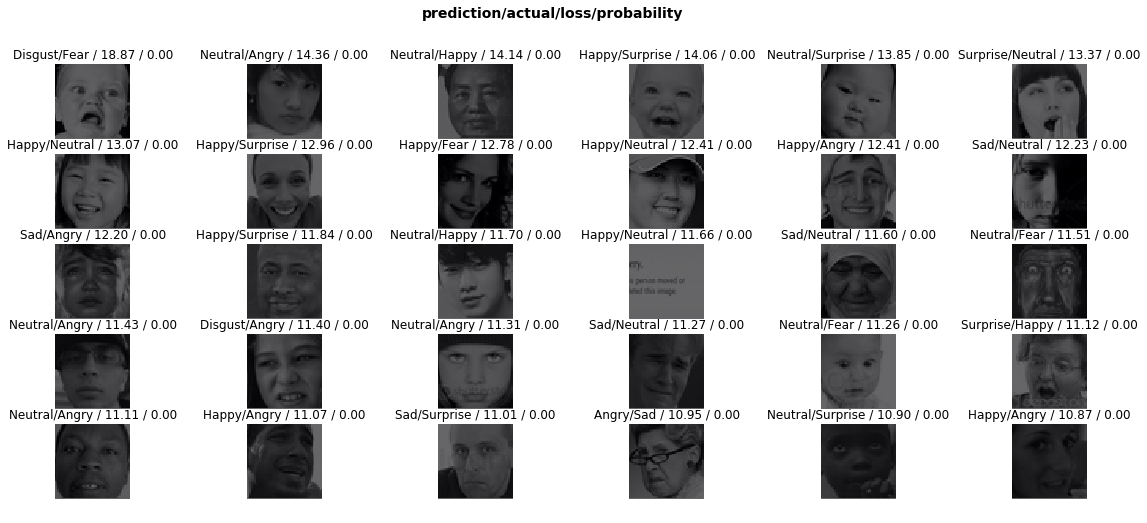

In [39]:
losses,idxs = interp.top_losses()
interp.plot_top_losses(30, figsize=(20,8))

Some of these are misinterpretations by the model, but most of them are wrong labels. Let's clean the data. 

### *Cleaning the data*

Facial expression recognition can be tricky because it is often subjective. However, looking at the top losses, we can see that some labels are not quite right. With fastai we can delete or re-label those images from the model to increase our accuracy. 

### *CNN from Scratch*

In [43]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [44]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [45]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [54]:
model_own = nn.Sequential(
    conv_and_res(3, 8), #24
    conv_and_res(8, 16),#12
    conv_and_res(16, 32),#6
    conv_and_res(32, 64),#3
    conv2(64, 128),#2
    nn.MaxPool2d(2,2),
    conv2(128, 7),#1
    Flatten(),
)

In [55]:
learn_own = Learner(data, model_own, loss_func = nn.CrossEntropyLoss(), metrics=accuracy, model_dir='/tmp/model/')
print(learn_own.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 24, 24]          216        True      
______________________________________________________________________
ReLU                 [8, 24, 24]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 24, 24]          16         True      
______________________________________________________________________
Conv2d               [8, 24, 24]          576        True      
______________________________________________________________________
ReLU                 [8, 24, 24]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 24, 24]          16         True      
______________________________________________________________________
Conv2d               [8, 24, 24]          576        True      
______________________________________________________________

In [56]:
learn_own.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.855371,1.832759,0.265111,00:46


In [57]:
#learn_own.unfreeze()
learn_own.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


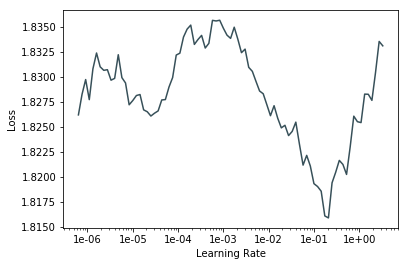

In [58]:
learn_own.recorder.plot()

In [59]:
learn_own.fit_one_cycle(30, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,1.661456,1.617376,0.364571,00:41
1,1.547948,1.554697,0.395576,00:44
2,1.507644,1.518741,0.404808,00:40
3,1.454826,1.425258,0.451141,00:42
4,1.426639,1.427039,0.456192,00:39
5,1.403885,1.413611,0.454450,00:43
6,1.377924,1.510110,0.415084,00:42
7,1.373387,1.331311,0.497474,00:44
8,1.349194,1.333343,0.479185,00:40
9,1.335205,1.362776,0.484585,00:41


In [ ]:
#learn_own.recorder.plot_losses()

### *CNN Features*

In [ ]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

## 6. The Model in Production

In [66]:
learn_own.export(wd+'/export.pkl')

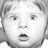

In [67]:
defaults.device = torch.device('cpu')
img = open_image('../input/fer2013-images/images/images_fer2013/PrivateTest/Surprise/33879.jpg')
img

In [68]:
learn = load_learner(wd)

In [69]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Surprise

In [ ]:
#learn.pred_batch
